## Task 1 - Zero-Shot Evaluation

In [1]:
# @title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch

print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.13.7 (main, Aug 15 2025, 12:34:02) [GCC 15.2.1 20250813]
CUDA   : 12.8
Torch  : 2.9.0+cu128
Device : NVIDIA GeForce RTX 4090
Tue Nov 11 03:34:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:1F:00.0 Off |                  Off |
| 33%   36C    P2             60W /  450W |   14719MiB /  24564MiB |      0%      Default |
|   

In [2]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, logging
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings

/home/course/select/b10401006/tmp2/mai-hw2/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14"  # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 1  # adjust based on your GPU memory
gradient_accumulation_steps = 1  # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 1
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# CLIP settings
# --- Load CLIP Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)


# --- Define a transform to process images for CLIP ---
class CLIPTransform:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        # The processor expects a PIL image or list of images
        # It returns a dict, we extract 'pixel_values'
        # .squeeze(0) removes the batch dimension the processor adds
        return self.processor(images=image, return_tensors="pt")[
            "pixel_values"
        ].squeeze(0)


clip_transform = CLIPTransform(processor)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
# dataset related imports
from torchvision.datasets import Flowers102
from datasets import load_dataset

# --- Flowers102 ---
# prepare Flowers102 dataset
flowers102_test_dts = Flowers102(
    root="../data", split="test", download=True
)  # evaluation on this set
print(f"Total test samples: {len(flowers102_test_dts)}")  # should be 6149

# prepare class names for Flowers102
with open("cat_to_name.json", "r") as f:
    cat_to_names = json.load(f)

flower_labels = [v for k, v in sorted(cat_to_names.items())]


# --- CUB-200-2011 ---
birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")
cub_bird_test_dts = birds_200["test"]
print(f"Total test samples: {len(cub_bird_test_dts)}")  # should be 5794


# prepare class names for CUB-200-2011
cub_labels = cub_bird_test_dts.features["label"].names

# === Create DataLoaders ===


class TransformDataset(Dataset):
    """Wrapper to apply transform to dataset"""

    def __init__(self, dataset, transform, is_hf_dataset=False):
        self.dataset = dataset
        self.transform = transform
        self.is_hf_dataset = is_hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.is_hf_dataset:
            # HuggingFace dataset format
            item = self.dataset[idx]
            image = item["image"]
            label = item["label"]
        else:
            # Torchvision dataset format
            image, label = self.dataset[idx]

        image = self.transform(image)
        return image, label


flower_dataloader = DataLoader(
    TransformDataset(flowers102_test_dts, transform=clip_transform, is_hf_dataset=False),
    batch_size=128,
    shuffle=False,
)
cub_dataloader = DataLoader(
    TransformDataset(cub_bird_test_dts, transform=clip_transform, is_hf_dataset=True),
    batch_size=128,
    shuffle=False,
)


Total test samples: 6149
Total test samples: 5794


In [6]:
print("--- Starting Method 1: Zero-Shot Classification ---")

# === 1. Load the full CLIP model ===
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()  # Set to evaluation mode

--- Starting Method 1: Zero-Shot Classification ---


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05,

In [ ]:
# === 2. Create and encode text prompts ===
flowers_prompts = [f"a photo of a {name}." for name in flower_labels]
flowers_text_inputs = processor(text=flowers_prompts, return_tensors="pt", padding=True).to(DEVICE)
flowers_text_features = model.get_text_features(**flowers_text_inputs)
flowers_text_features = flowers_text_features / flowers_text_features.norm(dim=-1, keepdim=True)  # Normalize

cub_bird_prompts = [f"a photo of a {name}." for name in cub_labels]
cub_bird_text_inputs = processor(text=cub_bird_prompts, return_tensors="pt", padding=True).to(DEVICE)
cub_bird_text_features = model.get_text_features(**cub_bird_text_inputs)
cub_bird_text_features = cub_bird_text_features / cub_bird_text_features.norm(dim=-1, keepdim=True)  # Normalize

In [ ]:
# === 3. Evaluate on the test set ===

# Set top-k value
TOP_K = 5  # You can change this value

# Flowers102 evaluation
flowers_labels = []
flowers_all_logits = []

with torch.no_grad():
    for images, labels in tqdm(flower_dataloader, desc="Evaluating Flowers102"):
        images = images.to(DEVICE)
        
        # Get image features [batch_size, embedding_dim]
        image_features = model.get_image_features(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute similarity: [batch_size, embedding_dim] @ [embedding_dim, num_classes] = [batch_size, num_classes]
        logits = image_features @ flowers_text_features.T
        
        flowers_labels.extend(labels.cpu().numpy())
        flowers_all_logits.append(logits.cpu())

flowers_labels = np.array(flowers_labels)
flowers_all_logits = torch.cat(flowers_all_logits, dim=0)  # [num_samples, num_classes]

# Compute top-1 and top-k predictions
flowers_top1_preds = flowers_all_logits.argmax(dim=-1).numpy()
flowers_topk_preds = flowers_all_logits.topk(TOP_K, dim=-1).indices.numpy()  # [num_samples, k]

# CUB-200-2011 evaluation
cub_bird_labels = []
cub_bird_all_logits = []

with torch.no_grad():
    for images, labels in tqdm(cub_dataloader, desc="Evaluating CUB-200-2011"):
        images = images.to(DEVICE)
        
        # Get image features [batch_size, embedding_dim]
        image_features = model.get_image_features(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute similarity: [batch_size, embedding_dim] @ [embedding_dim, num_classes] = [batch_size, num_classes]
        logits = image_features @ cub_bird_text_features.T
        
        cub_bird_labels.extend(labels.cpu().numpy())
        cub_bird_all_logits.append(logits.cpu())

cub_bird_labels = np.array(cub_bird_labels)
cub_bird_all_logits = torch.cat(cub_bird_all_logits, dim=0)  # [num_samples, num_classes]

# Compute top-1 and top-k predictions
cub_bird_top1_preds = cub_bird_all_logits.argmax(dim=-1).numpy()
cub_bird_topk_preds = cub_bird_all_logits.topk(TOP_K, dim=-1).indices.numpy()  # [num_samples, k]

# === 4. Result Analysis ===

# Compute accuracies
# Top-1 accuracy
flowers_top1_acc = np.mean(flowers_labels == flowers_top1_preds)
cub_bird_top1_acc = np.mean(cub_bird_labels == cub_bird_top1_preds)

# Top-k accuracy (true label is in top-k predictions)
flowers_topk_acc = np.mean([label in preds for label, preds in zip(flowers_labels, flowers_topk_preds)])
cub_bird_topk_acc = np.mean([label in preds for label, preds in zip(cub_bird_labels, cub_bird_topk_preds)])

# Display results
print(f"\n{'='*70}")
print(f"Zero-Shot Classification Results")
print(f"{'='*70}")
print(f"{'Dataset':<20} {'Top-1 Accuracy':<20} {'Top-{} Accuracy'.format(TOP_K):<20}")
print(f"{'-'*70}")
print(f"{'Flowers102':<20} {flowers_top1_acc * 100:>6.2f}%{'':<13} {flowers_topk_acc * 100:>6.2f}%")
print(f"{'CUB-200-2011':<20} {cub_bird_top1_acc * 100:>6.2f}%{'':<13} {cub_bird_topk_acc * 100:>6.2f}%")
print(f"{'='*70}\n")

# Store top-1 predictions for visualization (backward compatibility)
flowers_preds = flowers_top1_preds
cub_bird_preds = cub_bird_top1_preds

# Optional: Classification reports (using top-1 predictions)
print("Flowers102 Classification Report (Top-1):")
print(classification_report(flowers_labels, flowers_top1_preds, target_names=flower_labels, zero_division=0))

print("\nCUB-200-2011 Classification Report (Top-1):")
print(classification_report(cub_bird_labels, cub_bird_top1_preds, target_names=cub_labels, zero_division=0))

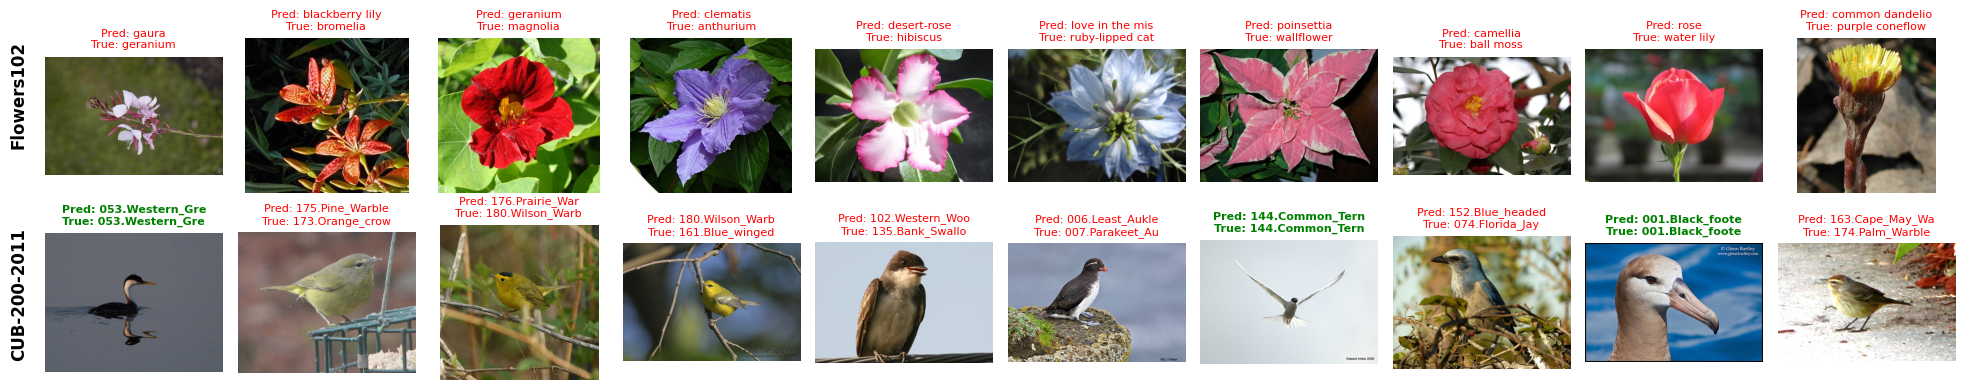

In [37]:
# === 5. Visualization ===
# Visualize predictions from both datasets

n_samples = 10
fig, axs = plt.subplots(2, n_samples, figsize=(20, 4))

# Random sample indices
np.random.seed(42)  # For reproducibility
flower_sample_idxs = np.random.choice(len(flowers_labels), n_samples, replace=False)
cub_bird_sample_idxs = np.random.choice(len(cub_bird_labels), n_samples, replace=False)

# Plot Flowers102 samples
for i, idx in enumerate(flower_sample_idxs):
    # Get original image from dataset (not transformed)
    original_image, true_label = flowers102_test_dts[idx]
    pred_label = flowers_preds[idx]
    
    axs[0, i].imshow(original_image)
    axs[0, i].axis('off')
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_label == true_label else 'red'
    axs[0, i].set_title(
        f"Pred: {flower_labels[pred_label][:15]}\nTrue: {flower_labels[true_label][:15]}", 
        fontsize=8, 
        color=color,
        weight='bold' if pred_label == true_label else 'normal'
    )

# Plot CUB-200-2011 samples
for i, idx in enumerate(cub_bird_sample_idxs):
    # Get original image from dataset (not transformed)
    original_image = cub_bird_test_dts[idx]['image']
    true_label = cub_bird_labels[idx]
    pred_label = cub_bird_preds[idx]
    
    axs[1, i].imshow(original_image)
    axs[1, i].axis('off')
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_label == true_label else 'red'
    axs[1, i].set_title(
        f"Pred: {cub_labels[pred_label][:15]}\nTrue: {cub_labels[true_label][:15]}", 
        fontsize=8, 
        color=color,
        weight='bold' if pred_label == true_label else 'normal'
    )

# Add row labels
fig.text(0.02, 0.75, 'Flowers102', va='center', rotation='vertical', fontsize=12, weight='bold')
fig.text(0.02, 0.25, 'CUB-200-2011', va='center', rotation='vertical', fontsize=12, weight='bold')

plt.tight_layout(rect=[0.03, 0, 1, 1])
plt.show()

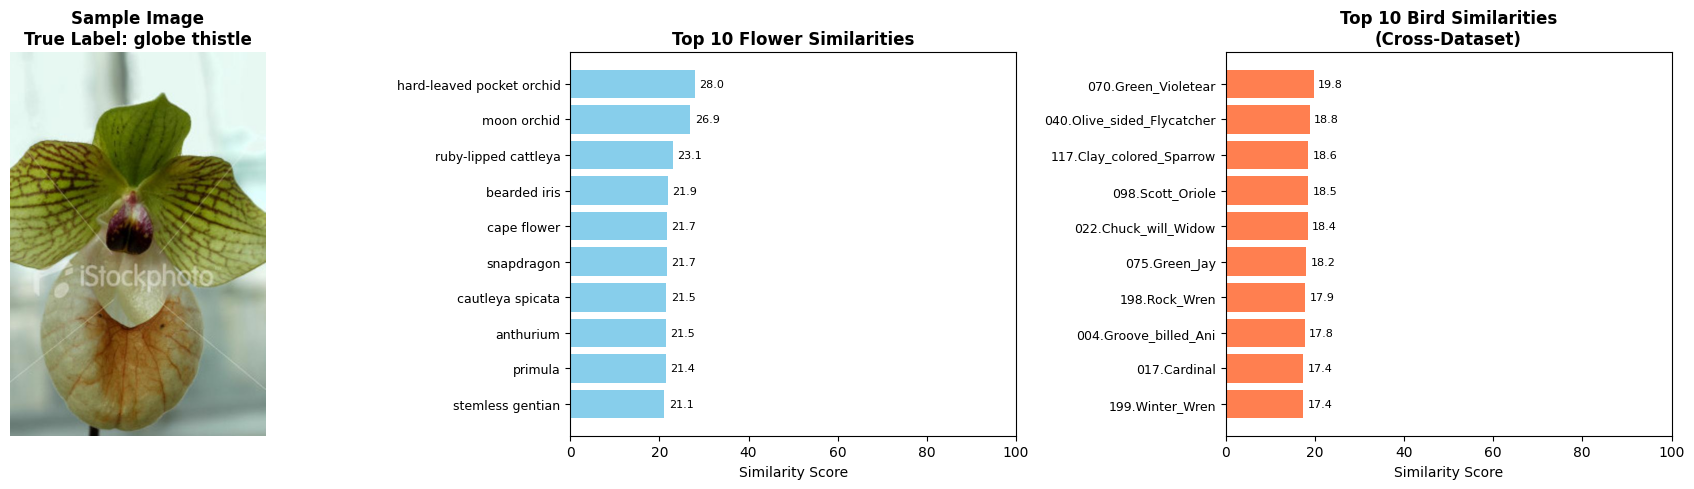


Cross-Dataset Similarity Analysis
Sample Image: globe thistle (Label: 1)

Flower Dataset:
  Max similarity:   27.99
  Mean similarity:  16.85
  Top prediction:  hard-leaved pocket orchid
  Prediction correct: False

Bird Dataset:
  Max similarity:   19.76
  Mean similarity:  12.42
  Top prediction:  070.Green_Violetear

Similarity Gap:
  Flower max - Bird max:   8.23
  (Positive value indicates higher confidence for flower)



In [38]:
# === 6. Cross-Dataset Similarity Analysis ===
# Sample a flower image and compare similarities with both flower and bird text prompts

sample_idx = 42  # Change this to explore different samples
sample_image, sample_label = flowers102_test_dts[sample_idx]  # Get original image
true_flower_name = flower_labels[sample_label]

# Encode the sample image
with torch.no_grad():
    image_input = clip_transform(sample_image).unsqueeze(0).to(DEVICE)
    image_features = model.get_image_features(pixel_values=image_input)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Compute similarities with both datasets
    flower_similarities = (100.0 * image_features @ flowers_text_features.T).squeeze(0).cpu().numpy()
    bird_similarities = (100.0 * image_features @ cub_bird_text_features.T).squeeze(0).cpu().numpy()

# Get top predictions
top_k = 10
flower_top_indices = np.argsort(flower_similarities)[-top_k:][::-1]
bird_top_indices = np.argsort(bird_similarities)[-top_k:][::-1]

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Sample Image
axes[0].imshow(sample_image)
axes[0].set_title(f'Sample Image\nTrue Label: {true_flower_name}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Plot 2: Top Flower similarities
flower_top_names = [flower_labels[i] for i in flower_top_indices]
flower_top_scores = flower_similarities[flower_top_indices]
colors = ['green' if i == sample_label else 'skyblue' for i in flower_top_indices]
axes[1].barh(range(top_k), flower_top_scores, color=colors)
axes[1].set_yticks(range(top_k))
axes[1].set_yticklabels(flower_top_names, fontsize=9)
axes[1].set_xlabel('Similarity Score', fontsize=10)
axes[1].set_title(f'Top {top_k} Flower Similarities', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].set_xlim([0, 100])
for i, v in enumerate(flower_top_scores):
    axes[1].text(v + 1, i, f'{v:.1f}', va='center', fontsize=8)

# Plot 3: Top Bird similarities (cross-dataset)
bird_top_names = [cub_labels[i] for i in bird_top_indices]
bird_top_scores = bird_similarities[bird_top_indices]
axes[2].barh(range(top_k), bird_top_scores, color='coral')
axes[2].set_yticks(range(top_k))
axes[2].set_yticklabels(bird_top_names, fontsize=9)
axes[2].set_xlabel('Similarity Score', fontsize=10)
axes[2].set_title(f'Top {top_k} Bird Similarities\n(Cross-Dataset)', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()
axes[2].set_xlim([0, 100])
for i, v in enumerate(bird_top_scores):
    axes[2].text(v + 1, i, f'{v:.1f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"Cross-Dataset Similarity Analysis")
print(f"{'='*60}")
print(f"Sample Image: {true_flower_name} (Label: {sample_label})")
print(f"\nFlower Dataset:")
print(f"  Max similarity:  {flower_similarities.max():6.2f}")
print(f"  Mean similarity: {flower_similarities.mean():6.2f}")
print(f"  Top prediction:  {flower_labels[flower_similarities.argmax()]}")
print(f"  Prediction correct: {flower_similarities.argmax() == sample_label}")
print(f"\nBird Dataset:")
print(f"  Max similarity:  {bird_similarities.max():6.2f}")
print(f"  Mean similarity: {bird_similarities.mean():6.2f}")
print(f"  Top prediction:  {cub_labels[bird_similarities.argmax()]}")
print(f"\nSimilarity Gap:")
print(f"  Flower max - Bird max: {flower_similarities.max() - bird_similarities.max():6.2f}")
print(f"  (Positive value indicates higher confidence for flower)")
print(f"{'='*60}\n")